# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 20.11.2020

Мягкий дедлайн: 00:59MSK 02.12.2019

Жесткий дедлайн: 00:59MSK 07.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

35.492402816107806

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [556]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float)
    each value is computed using bootstrap
    """
    sums = np.zeros_like(y)
    squares = np.zeros_like(y)
    error = np.zeros_like(y)
    K = np.zeros_like(y)  # number of times that each object was chosen

    samples = np.random.choice(
        X.shape[0], size=(num_runs, X.shape[0]), replace=True
    )

    for sample in range(0, num_runs):
        regressor.fit(X[samples[sample]], y[samples[sample]])
        out_of_bag = ~np.isin(np.arange(y.shape[0]), samples[sample])
        y_pred = regressor.predict(X[out_of_bag])

        sums[out_of_bag] = sums[out_of_bag] + y_pred
        squares[out_of_bag] = squares[out_of_bag] + y_pred ** 2
        K[out_of_bag] = K[out_of_bag] + 1
        error[out_of_bag] = error[out_of_bag] + (y_pred - y[out_of_bag]) ** 2

    out_of_bag = K != 0  # exclude elements that have never been used
    h = sums[out_of_bag] / K[out_of_bag]
    bias = np.mean(np.square(h - y[out_of_bag]))
    variance = np.mean((squares[out_of_bag] / K[out_of_bag]) - h ** 2)
    error = np.mean(error[out_of_bag] / K[out_of_bag])

    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [557]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [558]:
print(compute_biase_variance(LinearRegression(), X, y, num_runs=100))
print(compute_biase_variance(DecisionTreeRegressor(), X, y, num_runs=100))
print(compute_biase_variance(RandomForestRegressor(), X, y, num_runs=50))

(23.823549078583927, 0.9822576464783142, 24.80580672506227)
(11.264135820693667, 12.837243857194775, 24.101379677888445)
(11.068077434678006, 2.236519960988025, 13.304597395666045)


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Во-первых, получилось, что ошибка примерно равна сумме разброса и смещения. Во-вторых, видим, что самый большой разброс получился у решающего дерева, так как они склонны к обучению. Лучший результат показали случайные леса: у них и смещение небольшое относительно других моделей и разброс небольшой, они более точные, чем деревья, так как являются усреднением результатов деревьев, поэтому и разброс у таких моделей небольшой. 

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ в теории может уменьшать в Н раз, где н - это количество моделей, которое использовались в бэггинге, но это при условии, что базовые модели не коррелируют между собой. По полученным результатам видим, что между ними есть некая корреляция, поэтому в лучше случае разброс удалось уменьшить примерно в 4 раза: на решающем дереве. Действительно, мы знаем, что они склонны к переобучению, а с помощью бэггинга удалось избежать этого в некоторой степени.

In [536]:
from sklearn.ensemble import BaggingRegressor

In [559]:
compute_biase_variance(BaggingRegressor(LinearRegression(), n_estimators=100), X, y, num_runs=100)

(23.6995848443323, 0.8679534828739089, 24.56753832720623)

In [541]:
compute_biase_variance(BaggingRegressor(DecisionTreeRegressor(), n_estimators=10), X, y, num_runs=100)

(10.666297203908762, 3.2023599624751036, 13.868657166383851)

In [544]:
compute_biase_variance(BaggingRegressor(RandomForestRegressor(), n_estimators=10, n_jobs=-1), X, y, num_runs=50)

(11.584405500111393, 1.2888451486560284, 12.873250648767426)

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [591]:
from sklearn.model_selection import train_test_split

In [668]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects)
    samples = np.random.choice(X_train.shape[0], size=(num_runs, X_train.shape[0]), replace=True)
    
    for sample in range(0, num_runs):
        regressor.fit(X_train[samples[sample]], y_train[samples[sample]])
        y_pred = regressor.predict(X_test)
        plt.scatter(np.arange(num_test_objects), y_pred, color="lightblue", zorder=2)
        
    plt.scatter(np.arange(num_test_objects), y_test, color="black", marker="s", zorder=2)
    plt.title(title, fontsize=16)
    plt.xlabel("Object number", fontsize=12)
    plt.ylabel("Value", fontsize=12)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

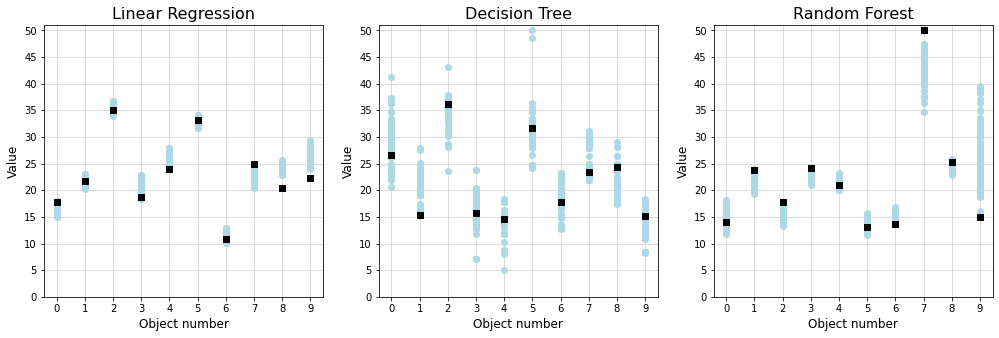

In [682]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

plt.subplot(1, 3, 1)
ax = fig.gca()
ax.set_ylim([0,51])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(0, 51, 5))
plt.grid(color="lightgrey", zorder=1)
plot_predictions(LinearRegression(), X, y, num_runs=100, num_test_objects=10, title="Linear Regression")

plt.subplot(1, 3, 2)
ax = fig.gca()
ax.set_ylim([0,51])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(0, 51, 5))
plt.grid(color="lightgrey", zorder=1)
plot_predictions(DecisionTreeRegressor(), X, y, num_runs=100, num_test_objects=10, title="Decision Tree")

plt.subplot(1, 3, 3)
ax = fig.gca()
ax.set_ylim([0,51])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(0, 51, 5))
plt.grid(color="lightgrey", zorder=1)
plot_predictions(RandomForestRegressor(), X, y, num_runs=100, num_test_objects=10, title="Random Forest")

plt.show()

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Ну-с, начнём с линейной регрессии: на графике видно, что предсказания не так сильно отдалены от настоящих ответов, это означает, что есть некоторое смещение, модель не совсем точно даёт предсказания. Но точки точки разположены достаточно близко друг к другу, то есть разброс небольшой. 

Перейдём к описанию графика решающего дерева. На графике видно, что иногда точки совпадают с верными ответами, однако всё равно очень много точек находятся далеко от верного ответа. Из этого следует, что у данной модели большой разброс (так как деревы склонны к переобучению), а также большое смещение.

Теперь посмотрим на последний график: график ответов случайного леса. В целом, видно, что модель с некоторой частотой угадывает верные ответы, а на многих объектах точки (ответы) расположены близко друг к другу. Но на нескольких объектах модель плохо угадывает ответ и её ответы сильно отличается между собой. Можно сделать вывод, что у модели должно быть не особо большое смещение, а также не очень большой разброс. Однако, те несколько объектов, на которых ответы были плохие (возможно, они являются выбросами), могут увеличивать разброс и смещение.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [690]:
bias_list, variance_list = [], []
for depth in range(1, 11):
    bias, variance, _ = compute_biase_variance(
        DecisionTreeRegressor(max_depth=depth),
        X,
        y,
        num_runs=100,
    )
    bias_list.append(bias)
    variance_list.append(variance)

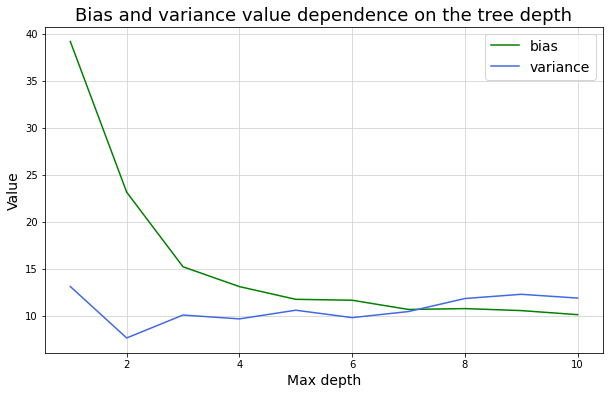

In [719]:
plt.figure(figsize=(10, 6))
plt.grid(color="lightgrey")
plt.plot(np.arange(1, 11), bias_list, color="green", label="bias")
plt.plot(np.arange(1, 11), variance_list, color="royalblue", label="variance")
plt.legend(fontsize="14")
plt.ylabel("Value", fontsize="14")
plt.xlabel("Max depth", fontsize="14")
plt.title("Bias and variance value dependence on the tree depth", fontsize="18")
plt.show()

In [723]:
bias_list, variance_list = [], []
for features in range(1, X.shape[1] + 1):
    bias, variance, _ = compute_biase_variance(
        DecisionTreeRegressor(max_features=features),
        X,
        y,
        num_runs=100,
    )
    bias_list.append(bias)
    variance_list.append(variance)

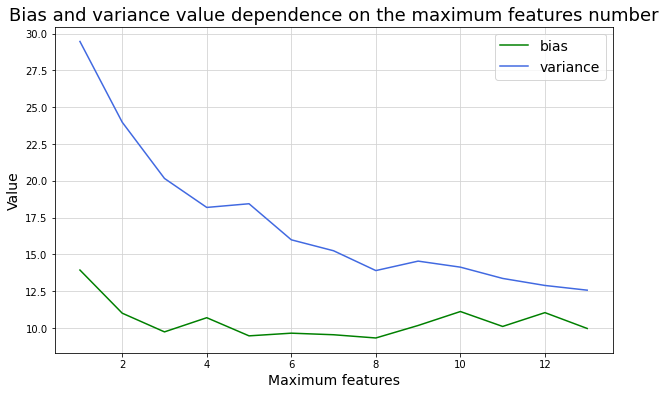

In [724]:
plt.figure(figsize=(10, 6))
plt.grid(color="lightgrey")
plt.plot(np.arange(1, X.shape[1] + 1), bias_list, color="green", label="bias")
plt.plot(np.arange(1, X.shape[1] + 1), variance_list, color="royalblue", label="variance")
plt.legend(fontsize="14")
plt.ylabel("Value", fontsize="14")
plt.xlabel("Maximum features", fontsize="14")
plt.title("Bias and variance value dependence on the maximum features number", fontsize="18")
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [728]:
bias_list, variance_list = [], []
for estimators in 2**np.arange(1, 10):
    bias, variance, _ = compute_biase_variance(
        RandomForestRegressor(n_estimators=estimators),
        X,
        y,
        num_runs=100,
    )
    bias_list.append(bias)
    variance_list.append(variance)

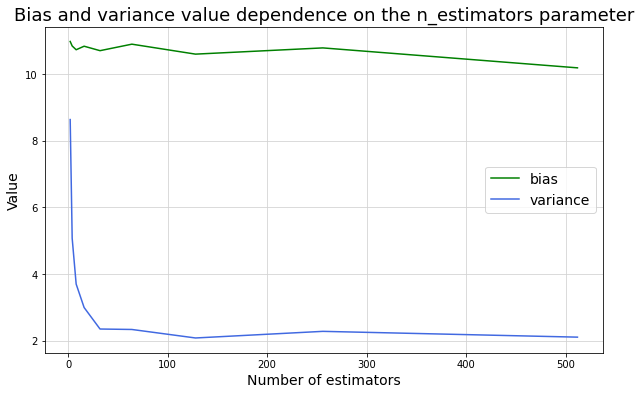

In [729]:
plt.figure(figsize=(10, 6))
plt.grid(color="lightgrey")
plt.plot(2**np.arange(1, 10), bias_list, color="green", label="bias")
plt.plot(2**np.arange(1, 10), variance_list, color="royalblue", label="variance")
plt.legend(fontsize="14")
plt.ylabel("Value", fontsize="14")
plt.xlabel("Number of estimators", fontsize="14")
plt.title("Bias and variance value dependence on the n_estimators parameter", fontsize="18")
plt.show()

In [730]:
from sklearn.ensemble import GradientBoostingRegressor

In [732]:
bias_list, variance_list = [], []
for estimators in 2**np.arange(1, 10):
    bias, variance, _ = compute_biase_variance(
        GradientBoostingRegressor(n_estimators=estimators),
        X,
        y,
        num_runs=50,
    )
    bias_list.append(bias)
    variance_list.append(variance)

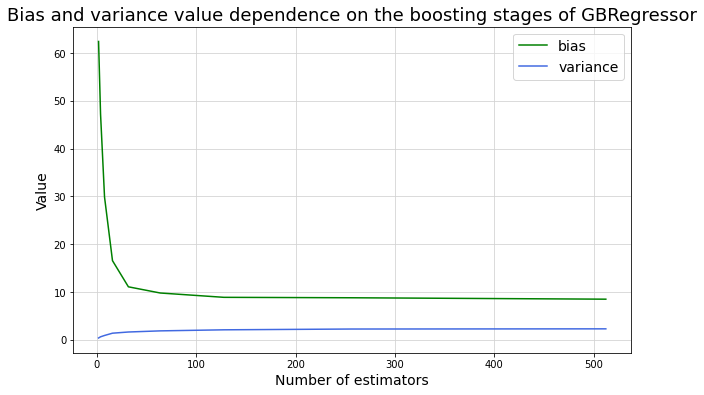

In [733]:
plt.figure(figsize=(10, 6))
plt.grid(color="lightgrey")
plt.plot(2**np.arange(1, 10), bias_list, color="green", label="bias")
plt.plot(2**np.arange(1, 10), variance_list, color="royalblue", label="variance")
plt.legend(fontsize="14")
plt.ylabel("Value", fontsize="14")
plt.xlabel("Number of estimators", fontsize="14")
plt.title("Bias and variance value dependence on the boosting stages of GBRegressor", fontsize="18")
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ 
1. Видим, что с глубиной дерева уменьшается смещение, то есть улучшается качество, так как мы позволяем его дообучиться до нужного результата. Однако после некоторой величины увеличивается разброс, так как начинается переобучение.
2. При увеличении количества рассматриваемых признаков при делении деревьев уменьшается разброс, это логично, потому что когда признаков мало, то дерево может делиться в некотором смысле рандомно, может не учитывать хорошие признаки, а с увеличением кол-ва рассматриваемых признаков повышается вероятность рассмотреть лучший признак на данном узле (node). Однако видим, что на смещение это повлияло мало, потому что деревьев много в лесу, а также запускали модель мы много раз, а признаков всего 13, поэтому, в целом, всё равно каждый полезный признак будет рассматриваться в каком-то дереве.
3. Этот график совпадает с тем, что нам рассказывали на лекции. Мы берём больше деревьев в лесу, из-за этого, конечно, же уменьшается разброс, потому что мы сильно усредняем результат каждого леса. Но смещение остаётся примерно таким же, на него это мало влияет, оно не будет сильно улучшаться, когда мы возьмём много моделей с примерно одинаковым смещением.
4. Повышение количество выполняемых этапов Gradient Boosting довольно устойчиво к переобучению, поэтому большое количество обычно приводит к лучшей производительности. Это мы и видим на последнем графике: разброс слегка увеличивается, но зато повышается качество обучения (уменьшается смещение).